In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

In [2]:
df_responses = pd.read_csv("kaggle_survey_2022_responses.csv",low_memory = False)
df_responses.head()

,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,...,Q44_3,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,"Are you currently a student? (high school, uni...",On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...
1,121,30-34,Man,India,No,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,462,30-34,Man,Algeria,No,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,293,18-21,Man,Egypt,Yes,Coursera,edX,NaN,DataCamp,NaN,...,NaN,"Kaggle (notebooks, forums, etc)",NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...","Podcasts (Chai Time Data Science, O’Reilly Dat...",NaN,NaN,NaN,NaN,NaN
4,851,55-59,Man,France,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,NaN,"Kaggle (notebooks, forums, etc)","Course Forums (forums.fast.ai, Coursera forums...",NaN,NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN


In [3]:
def getdata(dfl, colname, colmap=None, encode=True, dropcols=None):
"""
        returns one or more columns from the given dataframe
        
        Arguments
        ----------
        dfl: a dataframe
        colname: name or prefix of the column
        colmap: mapping of the column names (default = None)
        encode: encode the column values or not (default = True)
        dropcols: column names to drop (default = ["None", "Other"])
    """
    
    le = preprocessing.LabelEncoder()
    cols = dfl.columns[ dfl.columns.str.startswith(colname) ].to_list()
    data = dfl.loc[1:, cols]
    
    if colmap and len(colmap) > 0:
        data = data.rename(columns=colmap)
    
    if encode == True:
#         data = data.apply(le.fit_transform)
        data = data.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')
        data = (data == 0) * 1
    
    if dropcols and len(dropcols) > 0:
        data.drop(labels=dropcols, axis=1, inplace=True)
        
    
    return data

In [4]:
def aggregate(dfl, groupbycols, colname, agg="count"):
   """
        returns a dataframe with an aggregated measure grouped by one or more columns
        
        Arguments
        ----------
        dfl: a dataframe
        groupbycols: an array of one or more column name(s)
        colname: a column name on which the aggregation to be performed
        agg: the name of the aggregated measure (default: count)
        
        Return Values
        -------------
        grouped: a grouped dataframe with the aggregated measure and percent columns
    """
    
    grouped = dfl.groupby(groupbycols)[colname].agg([agg])\
                                               .reset_index()\
                                               .sort_values(by=[agg], ascending=False)
    
    grouped.rename(columns={colname: agg}, inplace=True)
    total = (grouped[agg]).sum()
    grouped["percent"] = grouped[agg] * 100. / total
    
    return grouped

In [5]:
def show_values_on_bars(labels, axs, h_v="v", space=0.4, labelsign=""):
  """
        annotates a bar chart
        
        Arguments
        ----------
        labels: a list of texts to show with each bar
        axs: matplotlib axis
        h_v: orientation (h: horizontal, v: vertical)
        space: space before the label
        labelsign: label suffix (default: '')
    """
    
    def _show_on_single_plot(ax):
        i = 0
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = "{:.1f}{}".format(labels[i], labelsign) 
                ax.text(_x, _y, value, ha="center", va="top", fontsize=11, fontweight="semibold") 
                i += 1
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - float(space)
                value = "{:.1f}{}".format(labels[i], labelsign) 
                ax.text(_x, _y, value, ha="left", va="center", fontsize=11, fontweight="semibold")
                i += 1
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [6]:
def show_bar(grp, xcol, ycol, labelcol, xlabel, ylabel, title, labelsign="", figsize=(10, 8)):
    """
        draws a labelled bar chart (orientation: horizontal)
        
        Arguments
        ----------
        grp: dataframe for plotting
        xcol: x-axis column name
        ycol: y-axis column name
        labelcol: label column name
        xlabel: x-axis label of the plot
        ylabel: y-axis label of the plot
        title: title of the plot
        labelsign: suffix of the label text (default: '')
        figsize: dimension of the matplotlib plot (default: (10, 8))
    """
    
    sns.set_theme(style="whitegrid")
    fig = plt.figure(figsize=figsize)

    ax = sns.barplot( x=xcol
                     ,y=ycol
                     ,data=grp
                     ,orient="h"
                     ,palette="cubehelix"
                   )

    if labelcol and len(labelcol) > 0:
        show_values_on_bars(grp.loc[:, labelcol].to_list(), ax, "h", 0.3, labelsign=labelsign)
        
    plt.ylabel(ylabel, fontweight="normal")
    plt.xlabel(xlabel, fontweight="normal")
    plt.title(title, fontweight="normal")

    plt.show()

In [7]:
def count_and_show(dfl, groupbycols, colname, ycol, xlabel, ylabel, title, labelsign="", figsize=(10, 8)):
  """
      shows a count plot of the dataframe
      
      Arguments
      ----------
      dfl: a dataframe
      groupbycols: an array of one or more column name(s)
      colname: a column name on which the aggregation to be performed
      ycol: y-axis column name
      xlabel: x-axis label of the plot
      ylabel: y-axis label of the plot
      title: title of the plot
      labelsign: suffix of the label text (default: '')
      figsize: dimension of the matplotlib plot (default: (10, 8))
    """
    
    xcol="count"
    
    grouped = aggregate(dfl
                       ,groupbycols
                       ,colname
                       )

    print( grouped.head() )
    
    show_bar(grp=grouped
            ,xcol=xcol
            ,ycol=ycol
            ,labelcol="percent"
            ,xlabel=xlabel
            ,ylabel=ylabel
            ,title=title
            ,labelsign=labelsign
            ,figsize=figsize
            )

In [8]:
map_lang = { 'Q12_1' : 'Python'
           , 'Q12_2' : 'R' 
            ,'Q12_3' : 'SQL' 
            ,'Q12_4' : 'C'
            ,'Q12_5' : 'C++' 
            ,'Q12_6' : 'Java' 
            ,'Q12_7' : 'Javascript' 
            ,'Q12_8' : 'Julia' 
            ,'Q12_9' : 'Bash' 
            ,'Q12_10' : 'MATLAB' 
            ,'Q12_11' : 'None' 
            ,'Q12_12' : 'Other' 
            ,'Q12_13' : 'C#'
            , 'Q12_14' : 'PHP'
            ,'Q12_15' :  'Go'}
map_activity = { 'Q28_1' : 'Analyze and understand data to influence product or business decisions'
                , 'Q28_2' :'Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data'
                ,'Q28_3' : 'Build prototypes to explore applying machine learning to new areas'
                ,'Q28_4' : 'Build and/or run a machine learning service that operationally improves my product or workflows'
                ,'Q28_5' : 'Experimentation and iteration to improve existing ML models'
                ,'Q28_6' : 'Do research that advances the state of the art of machine learning'
                ,'Q28_7' : 'None of these activities are an important part of my role at work'
                ,'Q28_8' : 'Other' }
map_viztools = {'Q15_1' : 'Matplotlib'
                ,'Q15_2' : 'Seaborn' 
                ,'Q15_3' : 'Plotly / Plotly Express' 
                ,'Q15_4' : 'Ggplot / ggplot2' 
                ,'Q15_5' : 'Shiny' 
                ,'Q15_6' : 'D3 js'
                ,'Q15_7' : 'Altair' 
                ,'Q15_8' : 'Bokeh' 
                ,'Q15_9' : 'Geoplotlib' 
                ,'Q15_10' : 'Leaflet / Folium' 
                ,'Q15_11' : 'Pygal' 
                ,'Q15_12' : 'Dygraphs' 
                ,'Q15_13' : 'Highcharter' 
                ,'Q15_14' : 'None' 
                ,'Q15_15' : 'Other'}
map_framework = { 'Q17_1' : 'Scikit-learn'
                 ,'Q17_2' : 'TensorFlow' 
                 ,'Q17_3' : 'Keras' 
                 ,'Q17_4' : 'PyTorch' 
                 ,'Q17_5' : 'Fast.ai' 
                 ,'Q17_6' : 'Xgboost' 
                 ,'Q17_7' : 'LightGBM' 
                 ,'Q17_8' : 'CatBoost' 
                 ,'Q17_9' : 'Caret' 
                 ,'Q17_10' : 'Tidymodels' 
                  ,'Q17_11' : 'JAX' 
                 ,'Q17_12' : 'PyTorch Lightning' 
                 ,'Q17_13' : 'Huggingface' 
                 ,'Q17_14' : 'None' 
                 ,'Q17_15' : 'Other'}
map_learning = { 'Q6_1' : 'Coursera'
                ,'Q6_2' : 'edX'
                ,'Q6_3' : 'Kaggle Learn Courses' 
                ,'Q6_4' : 'DataCamp' 
                ,'Q6_5' : 'Fast.ai' 
                ,'Q6_6' : 'Udacity' 
                ,'Q6_7' : 'Udemy' 
                ,'Q6_8' : 'LinkedIn Learning' 
                ,'Q6_9' : 'Cloud-certification programs (direct from AWS, Azure, GCP, or similar)' 
                ,'Q6_10' : 'University Courses (resulting in a university degree)' 
                ,'Q6_11' : 'None' 
                ,'Q6_12' : 'Other'}

In [31]:
def get_joint_prob(dfg, groupbycols, colname):
   """
        returns the joint probability distributions of the columns in a dataframe
        
        Arguments
        ---------
        dfg: an encoded dataframe (0-1 format)
        groupbycols: an array of one or more column name(s)
        colname: a column name on which the aggregation to be performed
        
        Return Values
        -------------
        grouped: a dataframe with the joint probabilities of the column combinations in dfg
        p: a column in grouped specifying the joint probability of the column value combinations
        rowsum: a column in grouped specifying how many columns are on (i.e., 1) in each column value combination
    """
    grouped = dfg.groupby(groupbycols)[colname].count().reset_index()
    grouped.rename(columns={colname: "count"}, inplace=True)
    grouped["p"] = grouped["count"] / grouped["count"].sum()
    grouped["rowsum"] = grouped[groupbycols].apply(sum, axis=1)
    
    return grouped

In [33]:
def sum_and_percent(dfg,groupbycols,colname):
     """
        returns a dataframe summed by one or more columns
        
        Arguments
        ----------
        dfl: a dataframe
        groupbycols: an array of one or more column name(s)
        colname: a column name on which the summation is to be performed
        sort: sort the group or not (default: False)
        
        Return Value
        ------------
        group: a grouped dataframe with sum and percent columns
    """
    group = dfg.groupby(groupbycols)[colname].sum().reset_index()
    group['percent'] = group[colname] * 100 / group[colname].sum()
   
    return group

In [36]:
def get_adjacency_list(dfg, cols):
    """
        returns the adjacency list of the dataframe
        
        Arguments
        ---------
        dfg: an encoded dataframe (0-1 format)
        cols: an array of selected column names
        
        Return Value
        ------------
        df_edges: a dataframe with ['Source', 'Target', 'Weight'] columns
        Source: the name of the source column
        Target: the name of the target column
        Weight: the joint probability of Source and Target occurring together
    """
    length = len(cols)
    df_edges = pd.DataFrame(np.arange(length * length).reshape(length, length))
    df_edges.index = cols
    df_edges.columns = cols
    df_edges.loc[:, :] = 0
    
    df_edges = df_edges.stack().reset_index()
    df_edges.columns = ['Source', 'Target', 'Weight']
    
    df_edges['Weight'] = df_edges[['Source', 'Target']].apply(lambda x: get_weight(dfg, x['Source'], x['Target'], 'p'), axis=1)
    
    return df_edges

In [ ]:
def get_weight(dfw, source, target, weight='p'):
    """
        returns the joint probability of source and target in dfw
        
        Arguments
        ---------
        dfw: a dataframe with column p (i.e., probability), source and target
        source: name of the source node
        target: name of the target node
        weight: the probability of source and target happening together
    """
    if source == target:
        return dfw.loc[ dfw[source] == 1, weight].sum()
    else:
        return dfw.loc[ (dfw[source] == 1) & (dfw[target] == 1) ,weight].sum()

In [ ]:
def get_importance(df_edgelist):
   """
        returns the normalized marginal probability of each node
        
        Arguments
        ---------
        df_edgelist: a dataframe in adjacency list format [Source, Target, Weight] columns
        
        Return Value
        ------------
        Importance: a column, specifying the relative value of each node with respect to the max weight
    """
    df_imp = df_edgelist[ df_edgelist["Source"] == df_edgelist["Target"] ]
    df_imp["Importance"] = df_imp["Weight"] * 100. / df_imp["Weight"].max()
    df_imp = df_imp.sort_values(by=["Importance"], ascending=False)
    return df_imp

In [ ]:
def get_pair_importance(df_edgelist):
    """
        returns the pairwise normalized probability of nodes
        
        Arguments
        ---------
        df_edgelist: a dataframe in adjacency list format [Source, Target, Weight] columns
        
        Return Value
        ------------
        Importance: a column, specifying the relative value of a nodepair or an edge with respect to the max edge-weight
    """
    df_imp = get_importance(df_edgelist)
    dictw = df_imp[["Source", "Importance"]].set_index("Source")["Importance"].to_dict()
    
    df_joint_imp = df_edgelist[ (df_edgelist["Source"] != df_edgelist["Target"]) ]
    df_joint_imp["Importance"] = df_joint_imp["Weight"] * 100. / df_joint_imp["Weight"].max()
    df_joint_imp["Displacement"] = df_joint_imp[["Source", "Target"]].apply(lambda x: dictw[x["Target"]] - dictw[x["Source"]], axis=1)
    df_joint_imp["SortedPairName"] = df_joint_imp[["Source", "Target"]].apply(lambda x: "_".join(sorted([x["Source"], x["Target"]])), axis=1)
    
    df_joint_imp = df_joint_imp.sort_values(by=["Displacement"], ascending=True) ## sort so that the most important source in (source, target) remains at the top
    df_joint_imp.drop_duplicates(subset=["SortedPairName"], keep="first", inplace=True) ## keep the pair with most important source
     
    df_joint_imp["Pair"] = df_joint_imp[["Source", "Target"]].apply(lambda x: "( {}, {} )".format(x["Source"], x["Target"]), axis=1 )
    df_joint_imp = df_joint_imp.sort_values(by=["Importance"], ascending=False)
    
    return df_joint_imp

In [9]:
df_prog = getdata(  dfl=df_responses
                  , colname="Q12"
                  , colmap=map_lang
                  , encode=True
                  , dropcols=["None","Other"]
                 )

df_prog["Python_R_MATLAB"] = df_prog[["Python", "R", "MATLAB"]].apply(sum, axis=1)

print("df_prog shape: ", df_prog.shape)

df_prog.head()

df_prog shape:  (23997, 14)


,Python,R,SQL,C,C++,Java,Javascript,Julia,Bash,MATLAB,C#,PHP,Go,Python_R_MATLAB
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,0,0,0,0,0,1
4,1,0,1,0,0,0,0,0,1,0,0,0,0,1
5,1,0,0,0,0,1,1,0,0,0,0,0,0,1


In [10]:
df_activity = getdata(  dfl=df_responses
                      , colname="Q28"
                      , colmap=map_activity
                      , encode=True
                      , dropcols=["None of these activities are an important part of my role at work", "Other"]
                     )
print("df_activity shape: ", df_activity.shape)

df_activity.head()

df_activity shape:  (23997, 6)


,Analyze and understand data to influence product or business decisions,"Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",Build prototypes to explore applying machine learning to new areas,Build and/or run a machine learning service that operationally improves my product or workflows,Experimentation and iteration to improve existing ML models,Do research that advances the state of the art of machine learning
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,1,1,1,0
5,0,0,0,0,0,0


In [11]:
df = pd.concat([df_prog["Python_R_MATLAB"], df_activity["Analyze and understand data to influence product or business decisions"]], axis=1)
df["DS"] = ((df["Python_R_MATLAB"] > 0) & (df["Analyze and understand data to influence product or business decisions"] > 0)) * 1
df.head()


,Python_R_MATLAB,Analyze and understand data to influence product or business decisions,DS
1,0,0,0
2,0,0,0
3,1,0,0
4,1,0,0
5,1,0,0


In [13]:
def get_cluster(dfl):
    """
        returns a cluster name based on Python/R/MATLAB expertise and data analysis
        
        Arguments
        ----------
        dfl: a dataframe
    """
    
    col1 = "Python_R_MATLAB"
    col2 = "Analyze and understand data to influence product or business decisions"
    
    if dfl[col1] > 0 and dfl[col2] > 0:
        return 'Python_R_MATLAB & Analysis'
    elif dfl[col1] > 0 and dfl[col2] == 0:
        return 'Lack Analysis'
    elif dfl[col1] == 0 and dfl[col2] > 0:
        return 'Lack Python_R_MATLAB'
    else:
        return 'Lack Both'
    
df["cluster"] = df.apply(get_cluster, axis=1)
df.head()

,Python_R_MATLAB,Analyze and understand data to influence product or business decisions,DS,cluster
1,0,0,0,Lack Both
2,0,0,0,Lack Both
3,1,0,0,Lack Analysis
4,1,0,0,Lack Analysis
5,1,0,0,Lack Analysis


In [12]:
print("Data Science Workforce: Count: {}, Percent: {:.2f}%".format( (df["DS"] > 0).sum(), (df["DS"] > 0).sum() * 100. / df.shape[0]))

Data Science Workforce: Count: 4357, Percent: 18.16%


                      cluster  count    percent
0               Lack Analysis  15105  62.945368
3  Python_R_MATLAB & Analysis   4357  18.156436
1                   Lack Both   3893  16.222861
2        Lack Python_R_MATLAB    642   2.675334


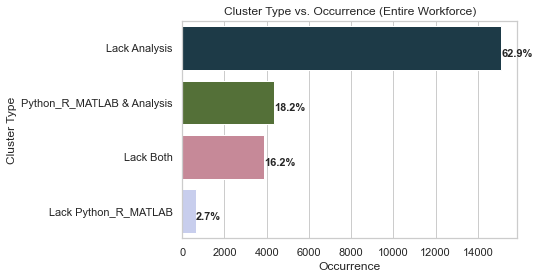

In [14]:
count_and_show( dfl=df
               ,groupbycols=["cluster"]
               ,colname="DS"
               ,ycol="cluster"
               ,xlabel="Occurrence"
               ,ylabel="Cluster Type"
               ,title="Cluster Type vs. Occurrence (Entire Workforce)"
               ,labelsign="%"
               ,figsize=(6, 4)
              )

  DS_Activity  count    percent
0          No  13818  91.479643
1         Yes   1287   8.520357


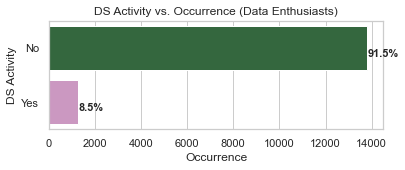

In [15]:
cols = ['Analyze and understand data to influence product or business decisions'
                , 'Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data'
                ,'Build prototypes to explore applying machine learning to new areas'
                ,'Build and/or run a machine learning service that operationally improves my product or workflows'
                ,'Experimentation and iteration to improve existing ML models'
                ,'Do research that advances the state of the art of machine learning'
       ]

df_enthus = pd.concat([df[["DS", "cluster"]], df_activity], axis=1)
df_enthus = df_enthus.loc[(df_enthus["cluster"] == "Lack Analysis"), cols ]
df_enthus["DS_Activity"] = ((df_enthus['Build prototypes to explore applying machine learning to new areas'] == 1) | 
                            (df_enthus['Experimentation and iteration to improve existing ML models'] == 1) |
                            (df_enthus['Do research that advances the state of the art of machine learning'] == 1)) * 1.

df_enthus["NonDS_Activity"] = ( (df_enthus['Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data'] == 1) |
                                (df_enthus['Build and/or run a machine learning service that operationally improves my product or workflows'] == 1)) * 1.


var_yes_no = {0: 'No' , 1: 'Yes' }
df_enthus["DS_Activity"] = df_enthus["DS_Activity"].map(var_yes_no)
df_enthus["NonDS_Activity"] = df_enthus["NonDS_Activity"].map(var_yes_no)

count_and_show( dfl=df_enthus[["DS_Activity", "NonDS_Activity"]]
               ,groupbycols=["DS_Activity"]
               ,colname="NonDS_Activity"
               ,ycol="DS_Activity"
               ,xlabel="Occurrence"
               ,ylabel="DS Activity"
               ,title="DS Activity vs. Occurrence (Data Enthusiasts)"
               ,labelsign="%"
               ,figsize=(6, 2)
              )

In [16]:
df_industry = getdata( dfl=df_responses
                     , colname="Q24"
                     , colmap=None
                     , encode=False
                     , dropcols=None
                    )

df_industry = df_industry.loc[:, "Q24"]
df_industry.head()

1                                       NaN
2                                       NaN
3                                       NaN
4    Online Service/Internet-based Services
5                                       NaN
Name: Q24, dtype: object

In [17]:
df = pd.concat([df,df_industry],axis = 1)
df.head()

,Python_R_MATLAB,Analyze and understand data to influence product or business decisions,DS,cluster,Q24
1,0,0,0,Lack Both,NaN
2,0,0,0,Lack Both,NaN
3,1,0,0,Lack Analysis,NaN
4,1,0,0,Lack Analysis,Online Service/Internet-based Services
5,1,0,0,Lack Analysis,NaN


                       Q24  count    percent
3     Computers/Technology   1064  24.420473
0      Academics/Education    508  11.659399
1       Accounting/Finance    464  10.649529
12                   Other    339   7.780583
9   Medical/Pharmaceutical    272   6.242828


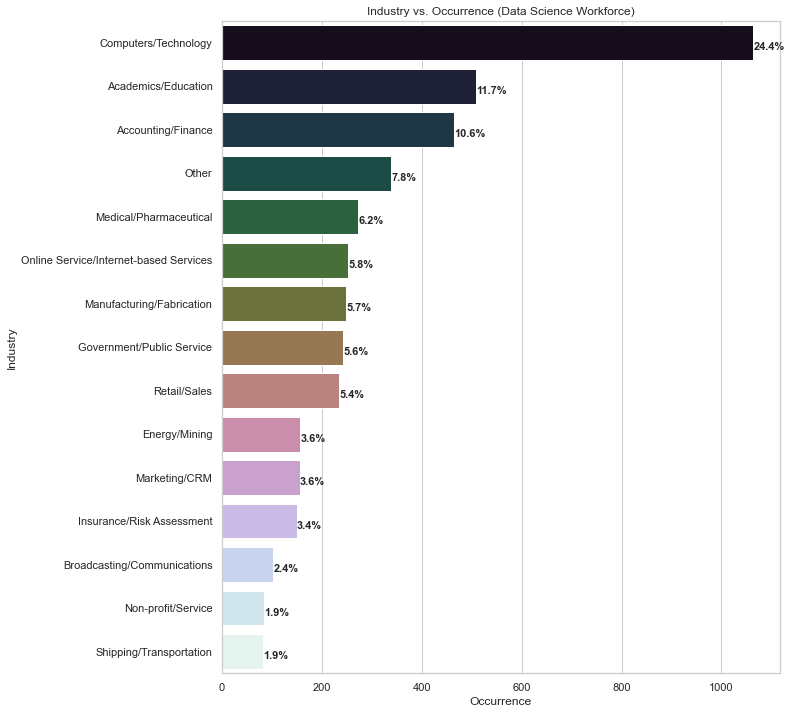

In [18]:
count_and_show(  df[df["DS"] > 0]
                ,groupbycols=["Q24"]
                ,colname="DS"
                ,ycol="Q24"
                ,xlabel="Occurrence"
                ,ylabel="Industry"
                ,title="Industry vs. Occurrence (Data Science Workforce)"
                ,labelsign="%"
                ,figsize=(10,12)
              )

In [19]:
df_occupation = getdata(df_responses,
                        colname = "Q23",
                        colmap = None,
                        encode = False,
                        dropcols = None)
df_occupation = df_occupation.loc[:"Q23"]
df_occupation.head()

,Q23
1,NaN
2,NaN
3,NaN
4,Data Scientist
5,NaN


In [20]:
df = pd.concat([df,df_occupation],axis = 1)
df.head()

,Python_R_MATLAB,Analyze and understand data to influence product or business decisions,DS,cluster,Q24,Q23
1,0,0,0,Lack Both,NaN,NaN
2,0,0,0,Lack Both,NaN,NaN
3,1,0,0,Lack Analysis,NaN,NaN
4,1,0,0,Lack Analysis,Online Service/Internet-based Services,Data Scientist
5,1,0,0,Lack Analysis,NaN,NaN


                                                  Q23  count    percent
4                                      Data Scientist   1322  30.341978
1   Data Analyst (Business, Marketing, Financial, ...    944  21.666284
8   Manager (Program, Project, Operations, Executi...    430   9.869176
11                                  Software Engineer    284   6.518246
7                    Machine Learning/ MLops Engineer    273   6.265779


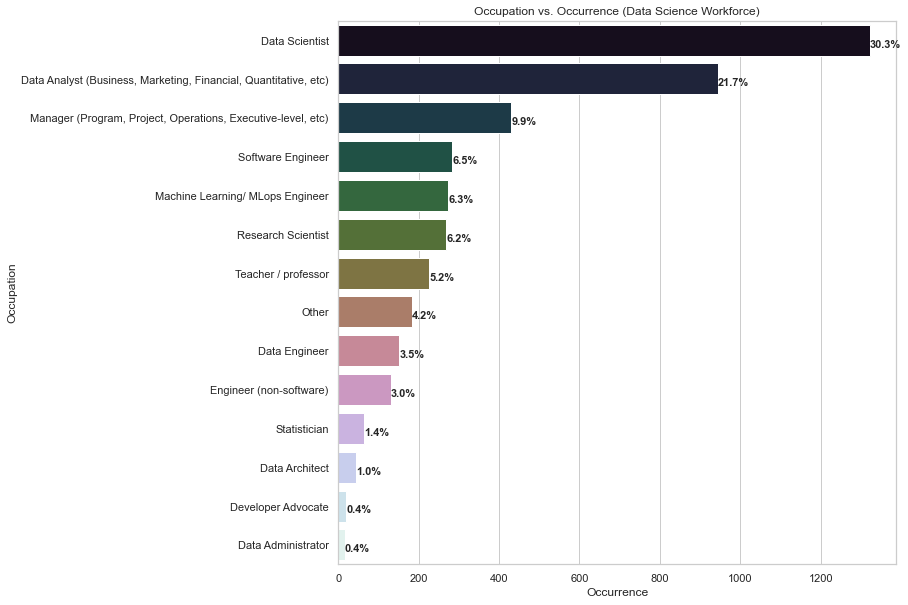

In [21]:
count_and_show(  df[df["DS"] > 0]
                ,groupbycols=["Q23"]
                ,colname="DS"
                ,ycol="Q23"
                ,xlabel="Occurrence"
                ,ylabel="Occupation"
                ,title="Occupation vs. Occurrence (Data Science Workforce)"
                ,labelsign="%"
                ,figsize=(10, 10)
              )

In [22]:
df_degree = getdata(df_responses,
                   colmap = None,
                   colname = "Q8",
                   dropcols = None,
                   encode = False)
df_degree = df_degree.loc[:,"Q8"]
df_degree.head()

1                                                  NaN
2                                      Master’s degree
3                                    Bachelor’s degree
4    Some college/university study without earning ...
5                                    Bachelor’s degree
Name: Q8, dtype: object

In [23]:
df = pd.concat([df,df_degree],axis = 1)
df.head()

,Python_R_MATLAB,Analyze and understand data to influence product or business decisions,DS,cluster,Q24,Q23,Q8
1,0,0,0,Lack Both,NaN,NaN,NaN
2,0,0,0,Lack Both,NaN,NaN,Master’s degree
3,1,0,0,Lack Analysis,NaN,NaN,Bachelor’s degree
4,1,0,0,Lack Analysis,Online Service/Internet-based Services,Data Scientist,Some college/university study without earning ...
5,1,0,0,Lack Analysis,NaN,NaN,Bachelor’s degree


                       Q8  count    percent
3         Master’s degree   2118  48.611430
0       Bachelor’s degree    985  22.607299
1         Doctoral degree    704  16.157907
2  I prefer not to answer    196   4.498508
5  Professional doctorate    141   3.236172


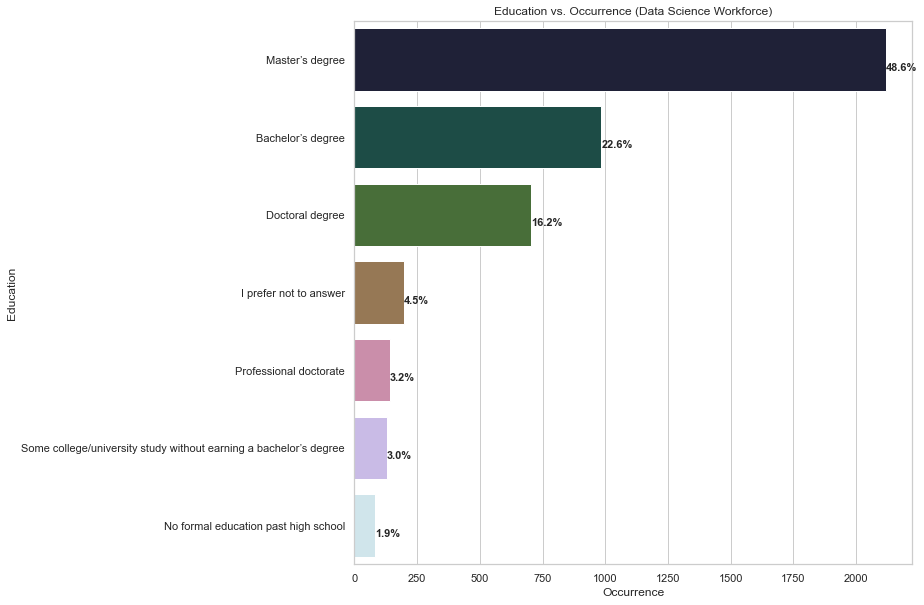

In [24]:
count_and_show(df[df["DS"]>0],
               groupbycols = ["Q8"],
               colname = "DS",
               ycol = "Q8",
               xlabel="Occurrence"
                ,ylabel="Education"
                ,title="Education vs. Occurrence (Data Science Workforce)"
                ,labelsign="%"
                ,figsize=(10, 10)
              )

In [25]:
df_progexp = getdata(df_responses,
                    colname = "Q11",
                    colmap = None,
                    encode = False,
                    dropcols = None)
df_progexp = df_progexp.loc[:"Q11"]
df_progexp.head()

,Q11
1,NaN
2,1-3 years
3,1-3 years
4,10-20 years
5,5-10 years


In [26]:
df = pd.concat([df,df_progexp],axis = 1)
df.head()

,Python_R_MATLAB,Analyze and understand data to influence product or business decisions,DS,cluster,Q24,Q23,Q8,Q11
1,0,0,0,Lack Both,NaN,NaN,NaN,NaN
2,0,0,0,Lack Both,NaN,NaN,Master’s degree,1-3 years
3,1,0,0,Lack Analysis,NaN,NaN,Bachelor’s degree,1-3 years
4,1,0,0,Lack Analysis,Online Service/Internet-based Services,Data Scientist,Some college/university study without earning ...,10-20 years
5,1,0,0,Lack Analysis,NaN,NaN,Bachelor’s degree,5-10 years


           Q11  count    percent
0    1-3 years    875  20.082626
4   5-10 years    857  19.669497
3    3-5 years    747  17.144824
1  10-20 years    714  16.387423
5    < 1 years    584  13.403718


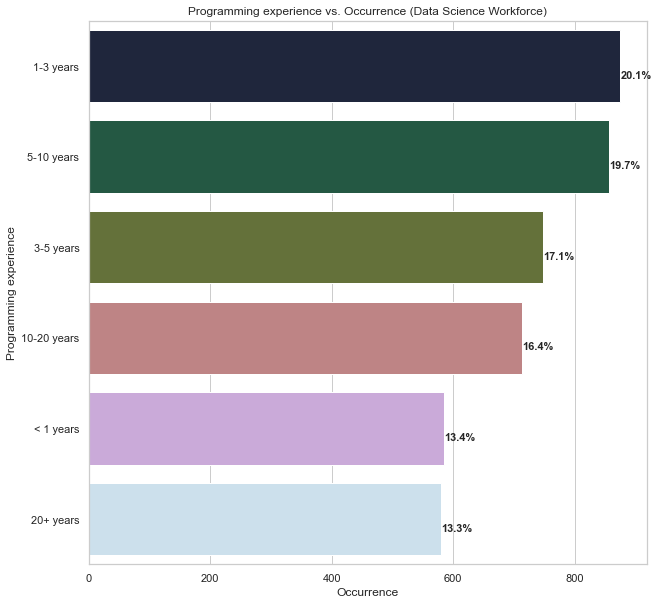

In [27]:
count_and_show(df[df["DS"]>0],
               groupbycols = ["Q11"],
               colname = "DS",
               ycol = "Q11",
               xlabel="Occurrence"
                ,ylabel="Programming experience"
                ,title="Programming experience vs. Occurrence (Data Science Workforce)"
                ,labelsign="%"
                ,figsize=(10, 10)
              )

In [28]:
df_mlexp = getdata( df_responses
                  , colname="Q16"
                  , colmap=None
                  , encode=False
                  , dropcols=None
                 )

df_mlexp.head()

,Q16
1,NaN
2,Under 1 year
3,1-2 years
4,1-2 years
5,I do not use machine learning methods


                                     Q16  count    percent
7                           Under 1 year    882  20.243287
0                              1-2 years    783  17.971081
2                              2-3 years    607  13.931604
5                             5-10 years    576  13.220106
6  I do not use machine learning methods    460  10.557723


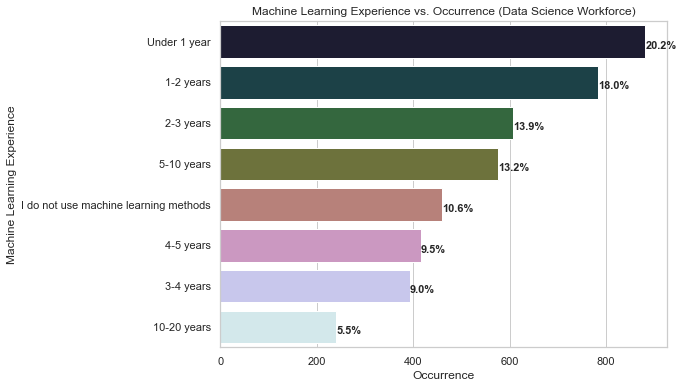

In [29]:
df = pd.concat([df,df_mlexp],axis = 1)
count_and_show(  df[df["DS"] > 0]
                ,groupbycols=["Q16"]
                ,colname="DS"
                ,ycol="Q16"
                ,xlabel="Occurrence"
                ,ylabel="Machine Learning Experience"
                ,title="Machine Learning Experience vs. Occurrence (Data Science Workforce)"
                ,labelsign="%"
                ,figsize=(8, 6)
              )

In [30]:
df.head()

,Python_R_MATLAB,Analyze and understand data to influence product or business decisions,DS,cluster,Q24,Q23,Q8,Q11,Q16
1,0,0,0,Lack Both,NaN,NaN,NaN,NaN,NaN
2,0,0,0,Lack Both,NaN,NaN,Master’s degree,1-3 years,Under 1 year
3,1,0,0,Lack Analysis,NaN,NaN,Bachelor’s degree,1-3 years,1-2 years
4,1,0,0,Lack Analysis,Online Service/Internet-based Services,Data Scientist,Some college/university study without earning ...,10-20 years,1-2 years
5,1,0,0,Lack Analysis,NaN,NaN,Bachelor’s degree,5-10 years,I do not use machine learning methods


In [32]:
cols = [ 'Python'
           , 'R' 
            ,'SQL' 
        ,'C'
            ,'C++' 
            ,'Java' 
            ,'Javascript' 
            ,'Julia' 
            ,'Bash' 
            ,'MATLAB'  
            ,'C#'
            ,'PHP'
            ,'Go']
df_grp = pd.concat([df_prog[cols],df['DS']],axis = 1)
df_grp.head()

grouped = get_joint_prob(df_grp.loc[df_grp['DS']>0],cols,'DS')
grouped

,Python,R,SQL,C,C++,Java,Javascript,Julia,Bash,MATLAB,C#,PHP,Go,count,p,rowsum
0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0.000459,1
1,0,0,0,0,0,0,0,1,0,1,0,0,0,2,0.000459,2
2,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0.000230,2
3,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0.000230,3
4,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0.000230,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,1,1,1,1,1,1,1,1,0,1,0,0,1,1,0.000230,10
421,1,1,1,1,1,1,1,1,0,1,1,0,0,1,0.000230,10
422,1,1,1,1,1,1,1,1,1,0,0,0,0,1,0.000230,9
423,1,1,1,1,1,1,1,1,1,1,1,0,0,2,0.000459,11


In [34]:
grouped_lang = sum_and_percent(grouped,'rowsum','count')
grouped_lang.head()

,rowsum,count,percent
0,1,870,19.967868
1,2,1455,33.394538
2,3,1079,24.764746
3,4,492,11.292174
4,5,224,5.141152


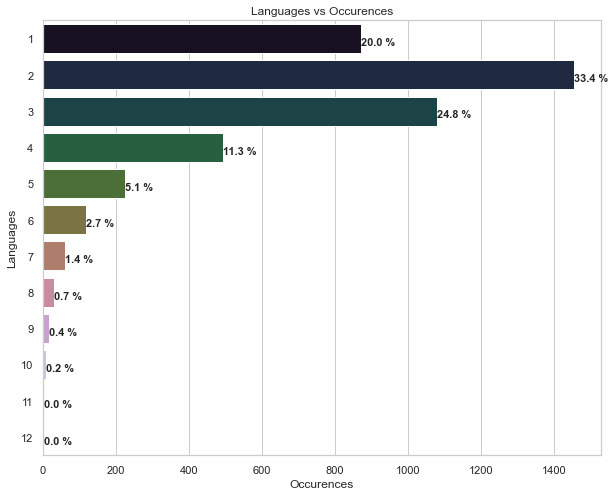

In [35]:
show_bar(grouped_lang
         ,xcol ='count'
         ,ycol ='rowsum'
         , labelcol = 'percent'
         , xlabel ='Occurences'
         , ylabel ='Languages'
         , title = 'Languages vs Occurences'
         , labelsign=" %"
         , figsize=(10, 8))

In [39]:
df_edges = get_adjacency_list(grouped, cols)
df_edges.head()

,Source,Target,Weight
0,Python,Python,0.944687
1,Python,R,0.249484
2,Python,SQL,0.570117
3,Python,C,0.099610
4,Python,C++,0.064953


In [40]:
df_imp = get_importance(df_edges)
df_imp.head()


<ipython-input-38-8d3c449d3c9c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imp["Importance"] = df_imp["Weight"] * 100. / df_imp["Weight"].max()


,Source,Target,Weight,Importance
0,Python,Python,0.944687,100.000000
28,SQL,SQL,0.598118,63.313897
14,R,R,0.299977,31.754130
98,Julia,Julia,0.147579,15.621963
112,Bash,Bash,0.129447,13.702624


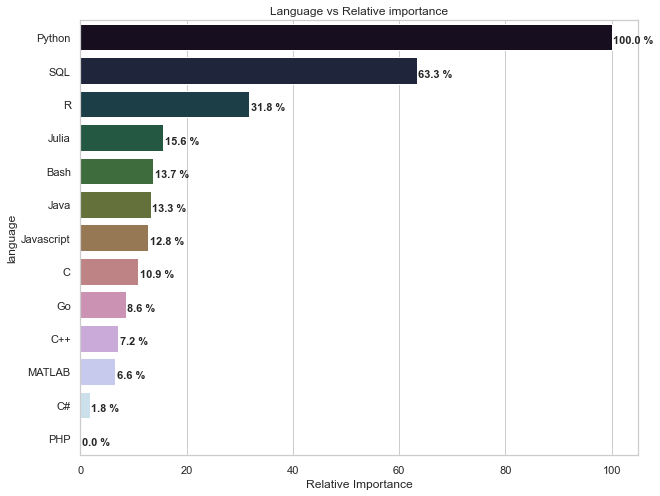

In [41]:
show_bar(df_imp
         ,xcol ='Importance'
         ,ycol ='Source'
         , labelcol = 'Importance'
         , xlabel ='Relative Importance'
         , ylabel ='language'
         , title = 'Language vs Relative importance'
         , labelsign=" %"
         , figsize=(10, 8))

In [43]:
df_joint_imp = get_pair_importance(df_edges)
df_joint_imp.head()


<ipython-input-38-8d3c449d3c9c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imp["Importance"] = df_imp["Weight"] * 100. / df_imp["Weight"].max()
<ipython-input-42-ad102b4f2aa1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joint_imp["Importance"] = df_joint_imp["Weight"] * 100. / df_joint_imp["Weight"].max()
<ipython-input-42-ad102b4f2aa1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

,Source,Target,Weight,Importance,Displacement,SortedPairName,Pair
2,Python,SQL,0.570117,100.000000,-36.686103,Python_SQL,"( Python, SQL )"
1,Python,R,0.249484,43.760064,-68.245870,Python_R,"( Python, R )"
27,SQL,R,0.201515,35.346216,-31.559767,R_SQL,"( SQL, R )"
7,Python,Julia,0.141611,24.838969,-84.378037,Julia_Python,"( Python, Julia )"
8,Python,Bash,0.125545,22.020934,-86.297376,Bash_Python,"( Python, Bash )"


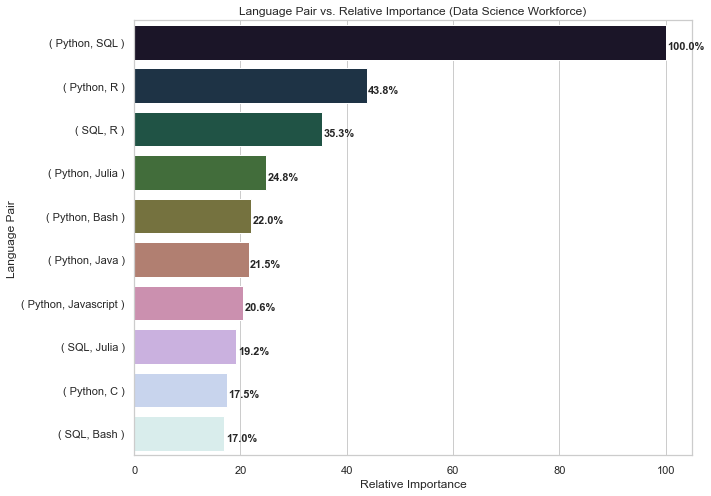

In [44]:
show_bar(  grp=df_joint_imp[:10]
         , xcol="Importance"
         , ycol="Pair"
         , labelcol="Importance"
         , xlabel="Relative Importance"
         , ylabel="Language Pair"
         , title="Language Pair vs. Relative Importance (Data Science Workforce)"
         , labelsign="%"
         , figsize=(10, 8)
        )

In [45]:
df_viz = getdata( dfl=df_responses
                , colname="Q15"
                , colmap=map_viztools
                , encode=True
                , dropcols=["None", "Other"]
               )

df_viz = pd.concat([df_viz, df_prog[["Python", "R"]], df["DS"]], axis=1)
df_viz.head()

,Matplotlib,Seaborn,Plotly / Plotly Express,Ggplot / ggplot2,Shiny,D3 js,Altair,Bokeh,Geoplotlib,Leaflet / Folium,Pygal,Dygraphs,Highcharter,Python,R,DS
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [46]:
(df_viz['DS'] > 0).sum()

4357

In [47]:
cols = ['Matplotlib',
        'Seaborn',
        'Plotly / Plotly Express', 
        'Ggplot / ggplot2' 
        ,'Shiny' 
        ,'D3 js' 
        ,'Altair' 
        ,'Bokeh' 
        ,'Geoplotlib' 
        ,'Leaflet / Folium' 
        ,'Pygal' 
        ,'Dygraphs' 
        ,'Highcharter' ]
grouped = get_joint_prob(df_viz.loc[(df_viz['DS']>0),:],cols,'DS')
grouped.head()

,Matplotlib,Seaborn,Plotly / Plotly Express,Ggplot / ggplot2,Shiny,D3 js,Altair,Bokeh,Geoplotlib,Leaflet / Folium,Pygal,Dygraphs,Highcharter,count,p,rowsum
0,0,0,0,0,0,0,0,0,0,0,0,0,0,449,0.103053,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.000230,1
2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.000230,1
3,0,0,0,0,0,0,0,0,0,0,1,0,0,5,0.001148,1
4,0,0,0,0,0,0,0,0,0,0,1,1,0,2,0.000459,2


In [48]:
grouped_viz = sum_and_percent(grouped,'rowsum','count')
grouped_viz.head()

,rowsum,count,percent
0,0,449,10.305256
1,1,656,15.056231
2,2,1339,30.732155
3,3,1024,23.502410
4,4,518,11.888914


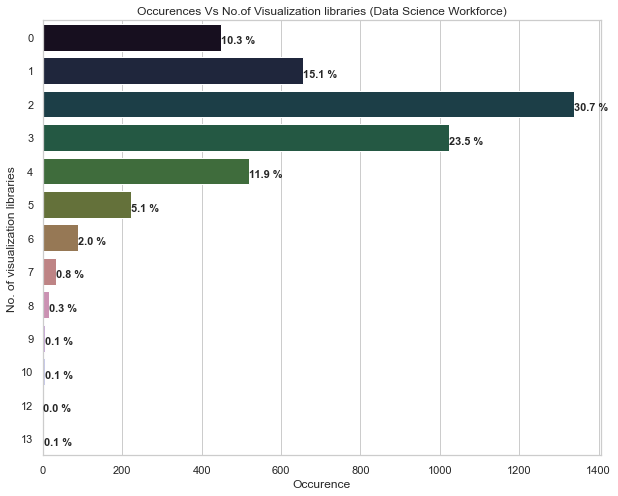

In [49]:
show_bar(  grp=grouped_viz
         , xcol="count"
         , ycol="rowsum"
         , labelcol="percent"
         , xlabel="Occurence"
         , ylabel="No. of visualization libraries"
         , title="Occurences Vs No.of Visualization libraries (Data Science Workforce)"
         , labelsign=" %"
         , figsize=(10, 8)
        )

       Source                   Target    Weight
0  Matplotlib               Matplotlib  0.757861
1  Matplotlib                  Seaborn  0.578150
2  Matplotlib  Plotly / Plotly Express  0.324306
3  Matplotlib         Ggplot / ggplot2  0.203121
4  Matplotlib                    Shiny  0.059904
                     Source                   Target    Weight  Importance
0                Matplotlib               Matplotlib  0.757861  100.000000
14                  Seaborn                  Seaborn  0.621070   81.950333
28  Plotly / Plotly Express  Plotly / Plotly Express  0.377553   49.818292
42         Ggplot / ggplot2         Ggplot / ggplot2  0.288042   38.007268
56                    Shiny                    Shiny  0.093413   12.325863


<ipython-input-38-8d3c449d3c9c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imp["Importance"] = df_imp["Weight"] * 100. / df_imp["Weight"].max()


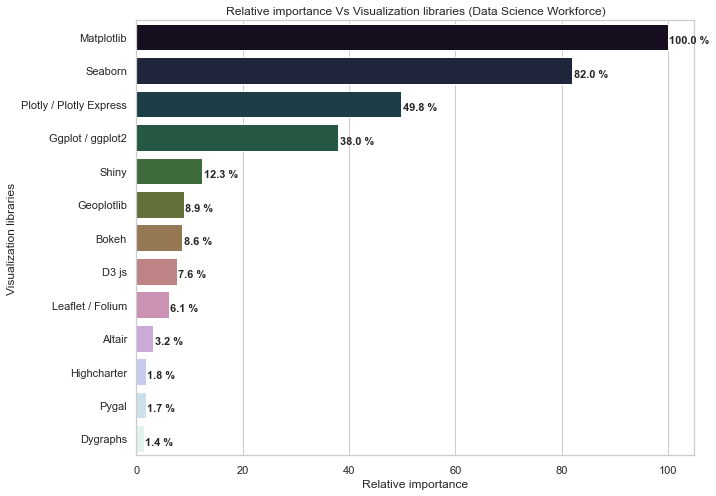

In [50]:
df_edges = get_adjacency_list(grouped, cols)
print(df_edges.head())
df_imp = get_importance(df_edges)
print(df_imp.head())
show_bar(  grp=df_imp
         , xcol="Importance"
         , ycol="Source"
         , labelcol="Importance"
         , xlabel="Relative importance"
         , ylabel="Visualization libraries"
         , title="Relative importance Vs Visualization libraries (Data Science Workforce)"
         , labelsign=" %"
         , figsize=(10, 8)
        )

In [51]:
df_joint_imp = get_pair_importance(df_edges)
df_joint_imp.head()

<ipython-input-38-8d3c449d3c9c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imp["Importance"] = df_imp["Weight"] * 100. / df_imp["Weight"].max()
<ipython-input-42-ad102b4f2aa1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joint_imp["Importance"] = df_joint_imp["Weight"] * 100. / df_joint_imp["Weight"].max()
<ipython-input-42-ad102b4f2aa1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

,Source,Target,Weight,Importance,Displacement,SortedPairName,Pair
1,Matplotlib,Seaborn,0.578150,100.000000,-18.049667,Matplotlib_Seaborn,"( Matplotlib, Seaborn )"
2,Matplotlib,Plotly / Plotly Express,0.324306,56.093688,-50.181708,Matplotlib_Plotly / Plotly Express,"( Matplotlib, Plotly / Plotly Express )"
15,Seaborn,Plotly / Plotly Express,0.293780,50.813815,-32.132041,Plotly / Plotly Express_Seaborn,"( Seaborn, Plotly / Plotly Express )"
3,Matplotlib,Ggplot / ggplot2,0.203121,35.132989,-61.992732,Ggplot / ggplot2_Matplotlib,"( Matplotlib, Ggplot / ggplot2 )"
16,Seaborn,Ggplot / ggplot2,0.168924,29.217944,-43.943065,Ggplot / ggplot2_Seaborn,"( Seaborn, Ggplot / ggplot2 )"


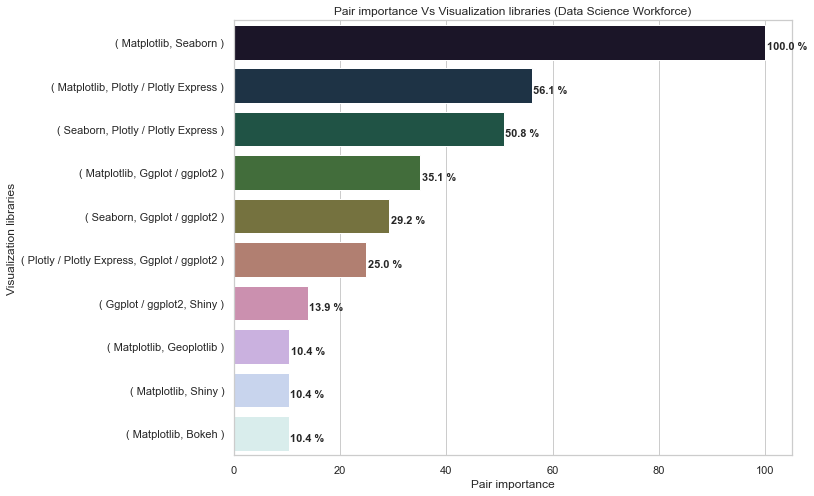

In [52]:
show_bar(  grp=df_joint_imp[:10]
         , xcol="Importance"
         , ycol="Pair"
         , labelcol="Importance"
         , xlabel="Pair importance"
         , ylabel="Visualization libraries"
         , title="Pair importance Vs Visualization libraries (Data Science Workforce)"
         , labelsign=" %"
         , figsize=(10, 8)
        )

In [53]:
df_mllib = getdata(  dfl=df_responses
                    , colname="Q17"
                    , colmap=map_framework
                    , encode=True
                    , dropcols=["None", "Other"]
                   )

df_mllib = pd.concat([df_mllib, df["DS"]], axis=1)
df_mllib.head()

,Scikit-learn,TensorFlow,Keras,PyTorch,Fast.ai,Xgboost,LightGBM,CatBoost,Caret,Tidymodels,JAX,PyTorch Lightning,Huggingface,DS
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,1,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
cols = ['Scikit-learn', 'TensorFlow', 'Keras', 'PyTorch', 'Fast.ai'
       , 'Xgboost', 'LightGBM', 'CatBoost',
       'Caret', 'Tidymodels', 'JAX', 'PyTorch Lightning', 'Huggingface']

grouped = get_joint_prob( df_mllib.loc[(df_mllib["DS"] > 0), :]
                        , cols
                        , "DS"
                        )

grouped.head()

,Scikit-learn,TensorFlow,Keras,PyTorch,Fast.ai,Xgboost,LightGBM,CatBoost,Caret,Tidymodels,JAX,PyTorch Lightning,Huggingface,count,p,rowsum
0,0,0,0,0,0,0,0,0,0,0,0,0,0,727,0.166858,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0.000459,1
2,0,0,0,0,0,0,0,0,0,0,0,1,0,6,0.001377,1
3,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0.000689,1
4,0,0,0,0,0,0,0,0,0,1,0,0,0,30,0.006885,1


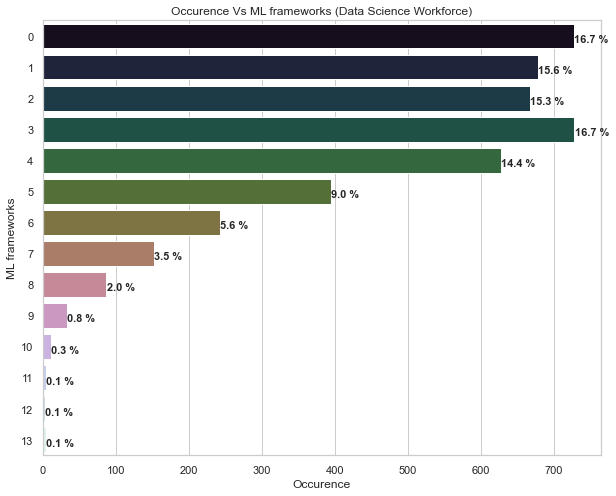

In [55]:
grouped_frame = sum_and_percent(grouped,'rowsum','count')
grouped_frame.head()
show_bar(  grp=grouped_frame
         , xcol="count"
         , ycol="rowsum"
         , labelcol="percent"
         , xlabel="Occurence"
         , ylabel="ML frameworks"
         , title="Occurence Vs ML frameworks (Data Science Workforce)"
         , labelsign=" %"
         , figsize=(10, 8)
        )

         Source        Target    Weight
0  Scikit-learn  Scikit-learn  0.708745
1  Scikit-learn    TensorFlow  0.374799
2  Scikit-learn         Keras  0.334863
3  Scikit-learn       PyTorch  0.265091
4  Scikit-learn       Fast.ai  0.039936
          Source        Target    Weight  Importance
0   Scikit-learn  Scikit-learn  0.708745  100.000000
14    TensorFlow    TensorFlow  0.440441   62.143782
28         Keras         Keras  0.374799   52.882124
70       Xgboost       Xgboost  0.364700   51.457254
42       PyTorch       PyTorch  0.309846   43.717617


<ipython-input-38-8d3c449d3c9c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imp["Importance"] = df_imp["Weight"] * 100. / df_imp["Weight"].max()


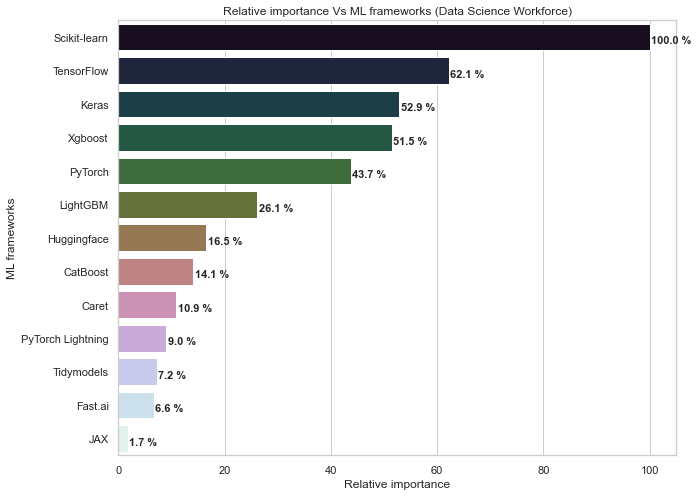

In [56]:
df_edges = get_adjacency_list(grouped, cols)
print(df_edges.head())
df_imp = get_importance(df_edges)
print(df_imp.head())
show_bar(  grp=df_imp
         , xcol="Importance"
         , ycol="Source"
         , labelcol="Importance"
         , xlabel="Relative importance"
         , ylabel="ML frameworks"
         , title="Relative importance Vs ML frameworks (Data Science Workforce)"
         , labelsign=" %"
         , figsize=(10, 8)
        )

In [57]:
df_activity = getdata(  dfl=df_responses
                    , colname="Q28"
                    , colmap=map_activity
                    , encode=True
                    , dropcols=["None of these activities are an important part of my role at work", "Other"]
                   )

df_activity = pd.concat([df_activity, df["DS"]], axis=1)
df_activity.head()

,Analyze and understand data to influence product or business decisions,"Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",Build prototypes to explore applying machine learning to new areas,Build and/or run a machine learning service that operationally improves my product or workflows,Experimentation and iteration to improve existing ML models,Do research that advances the state of the art of machine learning,DS
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,1,1,1,0,0
5,0,0,0,0,0,0,0


In [58]:
cols = ['Analyze and understand data to influence product or business decisions',
        'Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data', 
        'Build prototypes to explore applying machine learning to new areas',
        'Build and/or run a machine learning service that operationally improves my product or workflows',
        'Experimentation and iteration to improve existing ML models', 
        'Do research that advances the state of the art of machine learning'
       ]

grouped = get_joint_prob( df_activity.loc[(df_activity["DS"] > 0), :]
                        , cols
                        , "DS"
                        )

grouped.head()

,Analyze and understand data to influence product or business decisions,"Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",Build prototypes to explore applying machine learning to new areas,Build and/or run a machine learning service that operationally improves my product or workflows,Experimentation and iteration to improve existing ML models,Do research that advances the state of the art of machine learning,count,p,rowsum
0,1,0,0,0,0,0,1154,0.264861,1
1,1,0,0,0,0,1,83,0.019050,2
2,1,0,0,0,1,0,81,0.018591,2
3,1,0,0,0,1,1,48,0.011017,3
4,1,0,0,1,0,0,87,0.019968,2


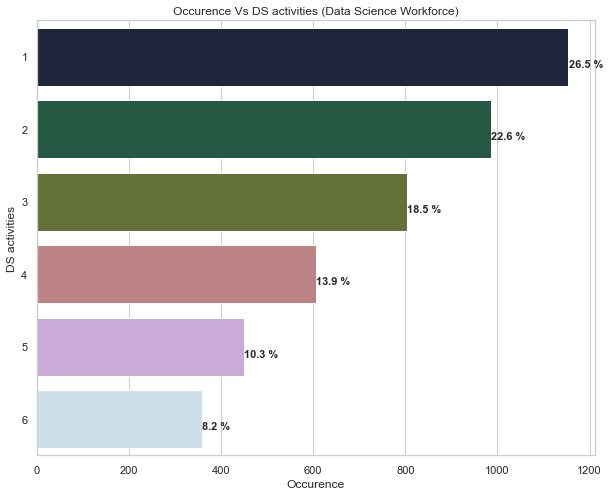

In [59]:
grouped_activity = sum_and_percent(grouped,'rowsum','count')
grouped_activity.head()
show_bar(  grp=grouped_activity
         , xcol="count"
         , ycol="rowsum"
         , labelcol="percent"
         , xlabel="Occurence"
         , ylabel="DS activities"
         , title="Occurence Vs DS activities (Data Science Workforce)"
         , labelsign=" %"
         , figsize=(10, 8)
        )

                                              Source  \
0  Analyze and understand data to influence produ...   
1  Analyze and understand data to influence produ...   
2  Analyze and understand data to influence produ...   
3  Analyze and understand data to influence produ...   
4  Analyze and understand data to influence produ...   

                                              Target    Weight  
0  Analyze and understand data to influence produ...  1.000000  
1  Build and/or run the data infrastructure that ...  0.433785  
2  Build prototypes to explore applying machine l...  0.477852  
3  Build and/or run a machine learning service th...  0.337618  
4  Experimentation and iteration to improve exist...  0.364700  
                                               Source  \
0   Analyze and understand data to influence produ...   
14  Build prototypes to explore applying machine l...   
7   Build and/or run the data infrastructure that ...   
28  Experimentation and iteration to improve 

<ipython-input-38-8d3c449d3c9c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imp["Importance"] = df_imp["Weight"] * 100. / df_imp["Weight"].max()


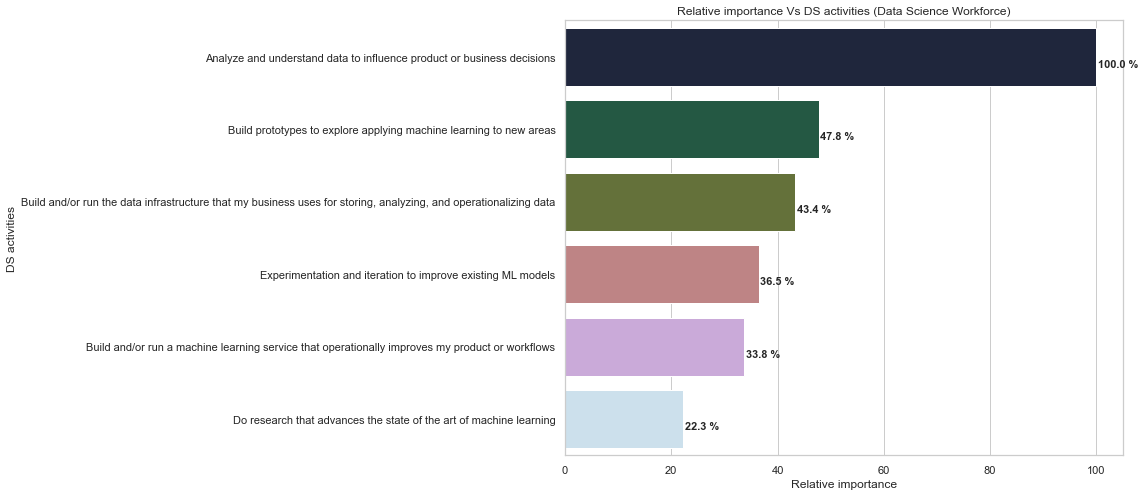

In [60]:
df_edges = get_adjacency_list(grouped, cols)
print(df_edges.head())
df_imp = get_importance(df_edges)
print(df_imp.head())
show_bar(  grp=df_imp
         , xcol="Importance"
         , ycol="Source"
         , labelcol="Importance"
         , xlabel="Relative importance"
         , ylabel="DS activities"
         , title="Relative importance Vs DS activities (Data Science Workforce)"
         , labelsign=" %"
         , figsize=(10, 8)
        )

In [61]:
df_learning = getdata(  dfl=df_responses
                    , colname="Q6"
                    , colmap=map_learning
                    , encode=True
                    , dropcols=["None", "Other"]
                   )

df_learning = pd.concat([df_learning, df["DS"]], axis=1)
df_learning.head()

,Coursera,edX,Kaggle Learn Courses,DataCamp,Fast.ai,Udacity,Udemy,LinkedIn Learning,"Cloud-certification programs (direct from AWS, Azure, GCP, or similar)",University Courses (resulting in a university degree),DS
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0
3,1,1,0,1,0,1,1,1,0,1,0
4,1,0,1,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0


In [62]:
cols = ['Coursera' ,'edX','Kaggle Learn Courses','DataCamp','Fast.ai','Udacity','Udemy','LinkedIn Learning',
        'Cloud-certification programs (direct from AWS, Azure, GCP, or similar)','University Courses (resulting in a university degree)'
       ]

grouped = get_joint_prob( df_learning.loc[(df_learning["DS"] > 0), :]
                        , cols
                        , "DS"
                        )

grouped.head()

,Coursera,edX,Kaggle Learn Courses,DataCamp,Fast.ai,Udacity,Udemy,LinkedIn Learning,"Cloud-certification programs (direct from AWS, Azure, GCP, or similar)",University Courses (resulting in a university degree),count,p,rowsum
0,0,0,0,0,0,0,0,0,0,0,634,0.145513,0
1,0,0,0,0,0,0,0,0,0,1,272,0.062428,1
2,0,0,0,0,0,0,0,0,1,0,21,0.004820,1
3,0,0,0,0,0,0,0,0,1,1,10,0.002295,2
4,0,0,0,0,0,0,0,1,0,0,25,0.005738,1


     Source                Target    Weight
0  Coursera              Coursera  0.521689
1  Coursera                   edX  0.135185
2  Coursera  Kaggle Learn Courses  0.203351
3  Coursera              DataCamp  0.152398
4  Coursera               Fast.ai  0.058297
                                               Source  \
0                                            Coursera   
66                                              Udemy   
22                               Kaggle Learn Courses   
99  University Courses (resulting in a university ...   
33                                           DataCamp   

                                               Target    Weight  Importance  
0                                            Coursera  0.521689  100.000000  
66                                              Udemy  0.337159   64.628245  
22                               Kaggle Learn Courses  0.317420   60.844699  
99  University Courses (resulting in a university ...  0.285747   54.773427  
33 

<ipython-input-38-8d3c449d3c9c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imp["Importance"] = df_imp["Weight"] * 100. / df_imp["Weight"].max()


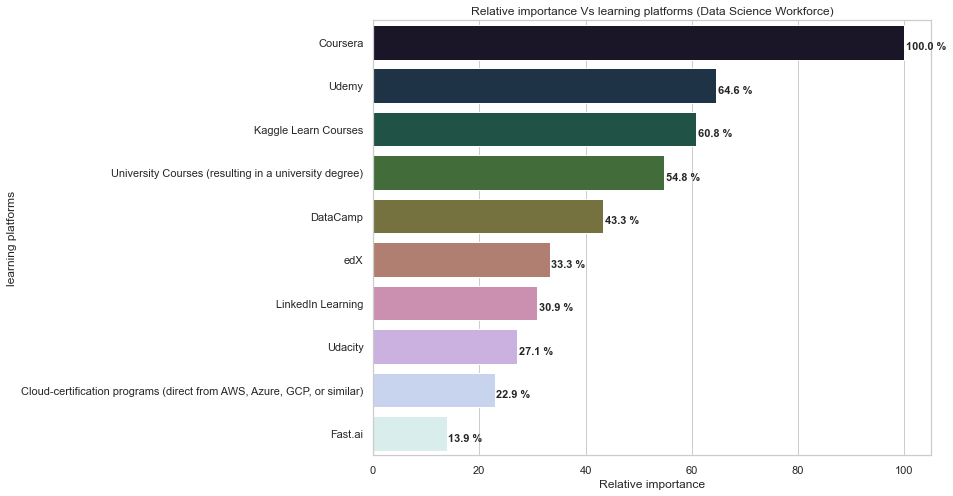

In [63]:
df_edges = get_adjacency_list(grouped, cols)
print(df_edges.head())
df_imp = get_importance(df_edges)
print(df_imp.head())
show_bar(  grp=df_imp
         , xcol="Importance"
         , ycol="Source"
         , labelcol="Importance"
         , xlabel="Relative importance"
         , ylabel="learning platforms"
         , title="Relative importance Vs learning platforms (Data Science Workforce)"
         , labelsign=" %"
         , figsize=(10, 8)
        )

In [64]:
df.head()

,Python_R_MATLAB,Analyze and understand data to influence product or business decisions,DS,cluster,Q24,Q23,Q8,Q11,Q16
1,0,0,0,Lack Both,NaN,NaN,NaN,NaN,NaN
2,0,0,0,Lack Both,NaN,NaN,Master’s degree,1-3 years,Under 1 year
3,1,0,0,Lack Analysis,NaN,NaN,Bachelor’s degree,1-3 years,1-2 years
4,1,0,0,Lack Analysis,Online Service/Internet-based Services,Data Scientist,Some college/university study without earning ...,10-20 years,1-2 years
5,1,0,0,Lack Analysis,NaN,NaN,Bachelor’s degree,5-10 years,I do not use machine learning methods


In [65]:
df_learn = getdata(  dfl=df_responses
                    , colname="Q6"
                    , colmap=None
                    , encode=False
                    , dropcols=None
                   )
df_learn['Learning'] = df_learn[df_learn.columns[:-1]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
df_learn.head()

,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q6_10,Q6_11,Q6_12,Learning
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,University Courses (resulting in a university ...,NaN,NaN,University Courses (resulting in a university ...
3,Coursera,edX,NaN,DataCamp,NaN,Udacity,Udemy,LinkedIn Learning,NaN,University Courses (resulting in a university ...,NaN,NaN,"Coursera,edX,DataCamp,Udacity,Udemy,LinkedIn L..."
4,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,NaN,Udemy,NaN,NaN,NaN,NaN,Other,"Coursera,Kaggle Learn Courses,Udemy"
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,


In [66]:
df_lang = getdata(  dfl=df_responses
                    , colname="Q12"
                    , colmap=None
                    , encode=False
                    , dropcols=None
                   )
df_lang['Languages'] = df_lang[df_lang.columns[:-1]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
df_lang.head()

,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_14,Q12_15,Languages
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2,NaN,NaN,NaN,NaN,NaN,NaN,Java,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Java
3,Python,NaN,SQL,C,NaN,NaN,NaN,NaN,NaN,NaN,MATLAB,NaN,NaN,NaN,NaN,"Python,SQL,C,MATLAB"
4,Python,NaN,SQL,NaN,NaN,NaN,NaN,NaN,Bash,NaN,NaN,NaN,NaN,NaN,NaN,"Python,SQL,Bash"
5,Python,NaN,NaN,NaN,NaN,C++,Java,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Python,C++,Java"


In [67]:
df_visual = getdata(  dfl=df_responses
                    , colname="Q15"
                    , colmap=None
                    , encode=False
                    , dropcols=None
                   )
df_visual['Visual'] = df_visual[df_visual.columns[:-1]].apply(lambda x : ','.join(x.dropna().astype(str)),axis = 1)
df_visual.head()

,Q15_1,Q15_2,Q15_3,Q15_4,Q15_5,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_11,Q15_12,Q15_13,Q15_14,Q15_15,Visual
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2,Matplotlib,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matplotlib
3,Matplotlib,Seaborn,Plotly / Plotly Express,NaN,NaN,NaN,NaN,NaN,Geoplotlib,NaN,NaN,NaN,NaN,NaN,NaN,"Matplotlib , Seaborn , Plotly / Plotly Expres..."
4,Matplotlib,Seaborn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Matplotlib , Seaborn"
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None


In [68]:
df_fworks = getdata(dfl = df_responses
                   ,colname = 'Q17'
                   ,colmap = False
                   ,encode = False
                   ,dropcols = None)
df_fworks['Frameworks'] = df_fworks[df_fworks.columns[:-1]].apply(lambda x:','.join(x.dropna().astype(str)),axis = 1)
df_fworks.head()

,Q17_1,Q17_2,Q17_3,Q17_4,Q17_5,Q17_6,Q17_7,Q17_8,Q17_9,Q17_10,Q17_11,Q17_12,Q17_13,Q17_14,Q17_15,Frameworks
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2,Scikit-learn,TensorFlow,NaN,PyTorch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Scikit-learn , TensorFlow , PyTorch"
3,Scikit-learn,NaN,NaN,PyTorch,NaN,Xgboost,NaN,NaN,NaN,NaN,NaN,PyTorch Lightning,NaN,NaN,NaN,"Scikit-learn , PyTorch , Xgboost , PyTorch L..."
4,Scikit-learn,NaN,NaN,PyTorch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Huggingface,NaN,NaN,"Scikit-learn , PyTorch , Huggingface"
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In [69]:
dataset = pd.concat([df,df_learn['Learning'],df_lang['Languages'],df_visual['Visual'],df_fworks['Frameworks']],axis = 1)
dataset.rename(columns = {'Q24' : 'Industry','Q23' : 'Job Title','Q8' : 'Education','Q11' : 'Programming experience','Q16' : 'Machine learning experience'}, inplace = True)


dataset.drop(['Python_R_MATLAB'],axis = 1,inplace = True)
dataset.head()

,Analyze and understand data to influence product or business decisions,DS,cluster,Industry,Job Title,Education,Programming experience,Machine learning experience,Learning,Languages,Visual,Frameworks
1,0,0,Lack Both,NaN,NaN,NaN,NaN,NaN,,,,
2,0,0,Lack Both,NaN,NaN,Master’s degree,1-3 years,Under 1 year,University Courses (resulting in a university ...,Java,Matplotlib,"Scikit-learn , TensorFlow , PyTorch"
3,0,0,Lack Analysis,NaN,NaN,Bachelor’s degree,1-3 years,1-2 years,"Coursera,edX,DataCamp,Udacity,Udemy,LinkedIn L...","Python,SQL,C,MATLAB","Matplotlib , Seaborn , Plotly / Plotly Expres...","Scikit-learn , PyTorch , Xgboost , PyTorch L..."
4,0,0,Lack Analysis,Online Service/Internet-based Services,Data Scientist,Some college/university study without earning ...,10-20 years,1-2 years,"Coursera,Kaggle Learn Courses,Udemy","Python,SQL,Bash","Matplotlib , Seaborn","Scikit-learn , PyTorch , Huggingface"
5,0,0,Lack Analysis,NaN,NaN,Bachelor’s degree,5-10 years,I do not use machine learning methods,,"Python,C++,Java",None,


In [70]:
dataset.dropna(axis = 0,how = 'any',inplace = True)
dataset.head()

,Analyze and understand data to influence product or business decisions,DS,cluster,Industry,Job Title,Education,Programming experience,Machine learning experience,Learning,Languages,Visual,Frameworks
4,0,0,Lack Analysis,Online Service/Internet-based Services,Data Scientist,Some college/university study without earning ...,10-20 years,1-2 years,"Coursera,Kaggle Learn Courses,Udemy","Python,SQL,Bash","Matplotlib , Seaborn","Scikit-learn , PyTorch , Huggingface"
8,1,1,Python_R_MATLAB & Analysis,Insurance/Risk Assessment,Software Engineer,Bachelor’s degree,10-20 years,4-5 years,"Coursera,edX,Udacity,Udemy","Python,SQL,C,Java,Javascript,PHP","Matplotlib , Ggplot / ggplot2 , D3 js , Geopl...","Scikit-learn , TensorFlow , Keras , PyTorch"
9,0,0,Lack Analysis,Government/Public Service,Research Scientist,Doctoral degree,20+ years,5-10 years,"Coursera,Kaggle Learn Courses",Python,Plotly / Plotly Express,Keras
11,0,0,Lack Analysis,Manufacturing/Fabrication,Other,Master’s degree,1-3 years,1-2 years,University Courses (resulting in a university ...,"Python,SQL","Matplotlib , Seaborn",Scikit-learn
14,0,0,Lack Analysis,Computers/Technology,Developer Advocate,Doctoral degree,10-20 years,5-10 years,"Coursera,Kaggle Learn Courses,Fast.ai,Udacity,...","Python,R,SQL","Seaborn , Plotly / Plotly Express , Ggplot / ...","Scikit-learn , TensorFlow , Keras , PyTorch..."


In [71]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in dataset.select_dtypes(include = ['object']).columns:
    le.fit(dataset[col])
    dataset[col] = le.transform(dataset[col])
dataset.shape

(8309, 12)

In [72]:
features = dataset.iloc[:,dataset.columns != 'Job Title']
predict = dataset.iloc[:,4]

In [73]:
predict.head()

4      4
8     11
9     10
11     9
14     5
Name: Job Title, dtype: int32

In [127]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
x_train,x_test,y_train,y_test = train_test_split(features,predict,test_size = 0.33,random_state = 0)

In [132]:
rndf_clf = RandomForestClassifier(random_state=6) # no need to scale features for random forest
rndf_clf.fit(x_train, y_train) 


RandomForestClassifier(random_state=6)

In [133]:
y_pred = rndf_clf.predict(x_test)
rndf_clf.score(x_test,y_test)

0.3760029175784099

In [134]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.40      0.53      0.46       436
           2       0.00      0.00      0.00        35
           3       0.07      0.02      0.03       110
           4       0.39      0.61      0.48       597
           5       0.00      0.00      0.00        17
           6       0.29      0.13      0.18       137
           7       0.20      0.12      0.15       179
           8       0.20      0.08      0.12       251
           9       0.25      0.14      0.18       189
          10       0.30      0.12      0.17       188
          11       0.40      0.46      0.42       325
          12       0.12      0.03      0.05        34
          13       0.51      0.74      0.60       229

    accuracy                           0.38      2742
   macro avg       0.22      0.21      0.20      2742
weighted avg       0.32      0.38      0.33      2742



In [145]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [5, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2', None]}

# Create a GridSearchCV object
grid_search = GridSearchCV(rndf_clf, param_grid, cv=5, n_jobs = -1)

# Fit the GridSearchCV object to the data
grid_search.fit(x_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best score:  0.4029112447797452


In [146]:
print(classification_report(y_test,grid_search.predict(x_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.42      0.55      0.48       436
           2       0.00      0.00      0.00        35
           3       0.00      0.00      0.00       110
           4       0.38      0.72      0.50       597
           5       0.00      0.00      0.00        17
           6       0.53      0.07      0.13       137
           7       0.20      0.08      0.12       179
           8       0.24      0.02      0.03       251
           9       0.27      0.13      0.17       189
          10       0.26      0.06      0.10       188
          11       0.37      0.48      0.41       325
          12       0.00      0.00      0.00        34
          13       0.50      0.81      0.62       229

    accuracy                           0.39      2742
   macro avg       0.23      0.21      0.18      2742
weighted avg       0.33      0.39      0.32      2742



c:\users\sai pratham\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sai pratham\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sai pratham\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa